In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import pybaseball
import statsapi
import warnings
from sklearn.linear_model import LogisticRegression
import datetime
import statsapi
import tqdm
import json
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

C:\Users\wmelville\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#calibration 
def calibration(preds, actuals, groupsize = 10000, title = '', xlab = 'Predicted Rate', ylab = 'Actual Rate'):

    sorted_preds = preds[np.argsort(preds)]
    sorted_actuals = actuals[np.argsort(preds)]
    predicted = []
    actual = []
    numgroups = len(preds) // groupsize
    for i in range(numgroups):
        if i == numgroups-1:
            rows = [j for j in range(i*groupsize, len(preds))]
        else:
            rows = [j for j in range(i*groupsize, (i+1) * groupsize)]
        group_preds = sorted_preds[rows]
        group_actuals = sorted_actuals[rows]
        actual.append(np.mean(group_actuals))
        predicted.append(np.mean(group_preds))

    plt.plot(predicted, actual, 'k.')
    plt.plot(predicted, predicted, 'r-')
    plt.xlabel(xlab)
    plt.title(title)
    plt.ylabel(ylab)
    
def calibration2(preds, y, n = 500):
    fig= plt.figure(figsize=(8,8))
    ax1 = plt.subplot(331)
    ax1 = calibration(preds[:,0], (y == 0).astype(bool).astype(int), n, title = 'In Play Out')

    ax2 = plt.subplot(332)
    ax2 = calibration(preds[:,1], (y == 1).astype(bool).astype(int), n, title = 'Single')

    ax3 = plt.subplot(333)
    ax3 = calibration(preds[:,2], (y == 2).astype(bool).astype(int), n, title = 'Double')

    ax4 = plt.subplot(334)
    ax4 = calibration(preds[:,3], (y == 3).astype(bool).astype(int), n, title = 'Triple')

    ax5 = plt.subplot(335)
    ax5 = calibration(preds[:,4], (y == 4).astype(bool).astype(int), n, title = 'HR')

    ax6 = plt.subplot(336)
    ax6 = calibration(preds[:,5], (y == 5).astype(bool).astype(int), n, title = 'HBP')

    ax7 = plt.subplot(337)
    ax7 = calibration(preds[:,6], (y == 6).astype(bool).astype(int), n, title = 'BB')

    ax8 = plt.subplot(338)
    ax8 = calibration(preds[:,7], (y == 7).astype(bool).astype(int), n, title = 'SO')

    plt.tight_layout()
    plt.show()

### Data

I'm planning to use Marcel projections (cite this https://www.tangotiger.net/archives/stud0346.shtml and maybe this https://baseballwithr.wordpress.com/2014/06/25/marcel-the-matrix/ ) as the inputs to the matchup model. Since I train the matchup model on 2019-2022 and test on 2023, and since Marcel goes back three years, I need data from 2016 through 2023.

The following cell is commented out because it's really slow to scrape all that data. I scrape it once then save it so I never have to do it again. Uncomment it out and run it if you haven't saved the data yet.

In [3]:
# raw23 = pybaseball.statcast('2023-01-01', '2023-12-01')
# raw23.to_csv('statcast/raw23.csv')

# raw22 = pybaseball.statcast(start_dt = '2022-01-01', end_dt = '2022-12-30')
# raw21 = pybaseball.statcast(start_dt = '2021-01-01', end_dt = '2021-12-01')
# raw20_19_18 = pybaseball.statcast(start_dt = '2018-01-01', end_dt = '2020-12-30')
# raw17_16 = pybaseball.statcast(start_dt = '2016-01-01', end_dt = '2017-12-15')
# raw22.to_csv('statcast/raw22.csv')
# raw21.to_csv('statcast/raw21.csv')
# raw20_19_18.to_csv('statcast/raw18_19_20.csv')
# raw17_16.to_csv('statcast/raw16_17.to_csv')

In [4]:
plays = pd.DataFrame()
#since there is a lot of data, to save RAM we read in one at a time and filter down from all pitches to just 
#PA and remove unnecessary columns 
for file in ['raw23.csv', 'raw22.csv', 'raw21.csv', 'raw18_19_20.csv', 'raw16_17.csv']:
    raw = pd.read_csv('statcast/' + file)
    raw = raw.loc[raw.events.isin(['strikeout', 'field_out', 'single', 'home_run', 'walk', 
                                        'fielders_choice_out', 'double', 'force_out', 'grounded_into_double_play',
                                        'hit_by_pitch', 'sac_fly', 'sac_bunt', 'fielders_choice',
                                        'triple', 'other_out', 'field_error', 'double_play',
                                        'strikeout_double_play', 'sac_fly_double_play',
                                        'triple_play'])]

    raw['outcome'] = -1
    raw.loc[raw.events.isin(['field_out', 'fielders_choice_out', 'force_out', 'grounded_into_double_play', 
                                'sac_fly', 'sac_bunt', 'fielders_choice', 'other_out', 'field_error', 
                                'double_play', 'sac_fly_double_play', 'triple_play']), 'outcome'] = 0
    raw['is_out'] = 0
    raw.loc[raw.outcome == 0, 'is_out'] = 1
    raw.loc[raw.events == 'single', 'outcome'] = 1
    raw['is_1b'] = 0
    raw.loc[raw.outcome == 1, 'is_1b'] = 1
    raw.loc[raw.events == 'double', 'outcome'] = 2
    raw['is_2b'] = 0
    raw.loc[raw.outcome == 2, 'is_2b'] = 1
    raw.loc[raw.events == 'triple', 'outcome'] = 3
    raw['is_3b'] = 0
    raw.loc[raw.outcome == 3, 'is_3b'] = 1
    raw.loc[raw.events == 'home_run', 'outcome'] = 4
    raw['is_hr'] = 0
    raw.loc[raw.outcome == 4, 'is_hr'] = 1
    raw.loc[raw.events == 'hit_by_pitch', 'outcome'] = 5
    raw['is_hbp'] = 0
    raw.loc[raw.outcome == 5, 'is_hbp'] = 1
    raw.loc[raw.events == 'walk', 'outcome'] = 6
    raw['is_bb'] = 0
    raw.loc[raw.outcome == 6, 'is_bb'] = 1
    raw.loc[raw.events.isin(['strikeout', 'strikeout_double_play']), 'outcome'] = 7
    raw['is_so'] = 0
    raw.loc[raw.outcome == 7, 'is_so'] = 1
    assert raw.loc[raw.outcome == -1].shape[0] == 0
    assert np.all(raw[['is_out', 'is_1b', 'is_2b', 'is_3b', 'is_hr', 'is_hbp', 'is_bb', 'is_so']].values.sum(axis = 1) == np.ones(raw.shape[0]))

    raw['year'] = [datetime.datetime.strptime(g, '%Y-%m-%d').year for g in raw.game_date.values]

    raw = raw[['game_date', 'game_pk', 'year', 'pitcher', 'p_throws', 'batter', 'stand', 'events', 'description', 
              'outcome', 'is_out', 'is_1b', 'is_2b', 'is_3b', 'is_hr', 'is_hbp', 'is_bb', 'is_so']]
    plays = pd.concat((plays, raw), ignore_index = True)
    
    del raw

### Marcel Projections

In [5]:
#calculate the league averages broken down by platoon 
lgavgs = plays.groupby(['year', 'p_throws', 'stand'], as_index = False).agg(xout = ('is_out', 'mean'),
                                                                           x1b = ('is_1b', 'mean'),
                                                                           x2b = ('is_2b', 'mean'),
                                                                           x3b = ('is_3b', 'mean'),
                                                                           xhr = ('is_hr', 'mean'),
                                                                           xhbp = ('is_hbp', 'mean'),
                                                                           xbb = ('is_bb', 'mean'),
                                                                           xso = ('is_so', 'mean'))
#get batter totals
batter_totals = plays.groupby(['year', 'batter', 'p_throws', 'stand'], as_index = False).agg(PA = ('is_out', 'count'),
                                                                                            outs = ('is_out', 'sum'),
                                                                                           singles = ('is_1b', 'sum'),
                                                                                           doubles = ('is_2b', 'sum'),
                                                                                           triples = ('is_3b', 'sum'),
                                                                                           hr = ('is_hr', 'sum'),
                                                                                           hbp = ('is_hbp', 'sum'),
                                                                                           bb = ('is_bb', 'sum'),
                                                                                           so = ('is_so', 'sum'))

pitcher_totals = plays.groupby(['year', 'pitcher', 'p_throws', 'stand'], as_index = False).agg(PA = ('is_out', 'count'),
                                                                                            outs = ('is_out', 'sum'),
                                                                                           singles = ('is_1b', 'sum'),
                                                                                           doubles = ('is_2b', 'sum'),
                                                                                           triples = ('is_3b', 'sum'),
                                                                                           hr = ('is_hr', 'sum'),
                                                                                           hbp = ('is_hbp', 'sum'),
                                                                                           bb = ('is_bb', 'sum'),
                                                                                           so = ('is_so', 'sum'))

                                                                                               
#get the batters and pitchers that we need marcel projections for. Basically, if these batters are missing
#in the data, we will set the values to zero. Training data starts in 2019 and goes to 2022. Test data 
#starts in 2023
needed_plays = plays.loc[plays.year > 2018]
needed_batters = needed_plays.drop_duplicates(subset = ['year', 'batter', 'p_throws', 'stand'])[['year', 'batter', 'p_throws', 'stand']]
needed_pitchers = needed_plays.drop_duplicates(subset = ['year', 'pitcher', 'p_throws', 'stand'])[['year', 'pitcher', 'p_throws', 'stand']]

#add in a generic batter and pitcher with ID 0. Since these players have no data in plays, their projections will
#get regressed all the way to the mean. We'll use these players when we need a projection for a brand new player
#who has never played in the big leagues before.
gen_batter = pd.DataFrame({'year': [2023, 2023, 2023, 2023], 'batter': [0, 0, 0, 0], 
                           'p_throws': ['L', 'R', 'L', 'R'], 'stand': ['R', 'R', 'L', 'L']})
needed_batters = pd.concat((needed_batters, gen_batter), ignore_index = True)
gen_pitcher = pd.DataFrame({'year': [2023, 2023, 2023, 2023], 'pitcher': [0, 0, 0, 0], 
                           'p_throws': ['L', 'R', 'L', 'R'], 'stand': ['R', 'R', 'L', 'L']})
needed_pitchers = pd.concat((needed_pitchers, gen_pitcher), ignore_index = True)

#define the previous three years in the needed players tables 
needed_batters['year1'] = needed_batters.year.values - 1
needed_batters['year2'] = needed_batters.year.values - 2
needed_batters['year3'] = needed_batters.year.values - 3
needed_pitchers['year1'] = needed_pitchers.year.values - 1
needed_pitchers['year2'] = needed_pitchers.year.values - 2
needed_pitchers['year3'] = needed_pitchers.year.values - 3

#left join needed players with the totals on the prior 3 years, so if there is no match it'll get set to 0 
#year 1 
batter_totals.columns = ['year1', 'batter', 'p_throws', 'stand', 'PA1', 'outs1', 'singles1', 'doubles1', 
                         'triples1', 'hr1', 'hbp1', 'bb1', 'so1']
pitcher_totals.columns = ['year1', 'pitcher', 'p_throws', 'stand', 'PA1', 'outs1', 'singles1', 'doubles1', 
                         'triples1', 'hr1', 'hbp1', 'bb1', 'so1']
needed_batters = needed_batters.merge(batter_totals, on = ['year1', 'batter', 'p_throws', 'stand'], how = 'left')
needed_pitchers = needed_pitchers.merge(pitcher_totals, on = ['year1', 'pitcher', 'p_throws', 'stand'], how = 'left')

lgavgs.columns = ['year1', 'p_throws', 'stand', 'xout1', 'x1b1', 'x2b1', 'x3b1', 'xhr1', 'xhbp1', 'xbb1', 'xso1']
needed_batters = needed_batters.merge(lgavgs, on = ['year1', 'p_throws', 'stand'], how = 'inner')
needed_pitchers = needed_pitchers.merge(lgavgs, on = ['year1', 'p_throws', 'stand'], how = 'inner')

#year 2
batter_totals.columns = ['year2', 'batter', 'p_throws', 'stand', 'PA2', 'outs2', 'singles2', 'doubles2', 
                         'triples2', 'hr2', 'hbp2', 'bb2', 'so2']
pitcher_totals.columns = ['year2', 'pitcher', 'p_throws', 'stand', 'PA2', 'outs2', 'singles2', 'doubles2', 
                         'triples2', 'hr2', 'hbp2', 'bb2', 'so2']
needed_batters = needed_batters.merge(batter_totals, on = ['year2', 'batter', 'p_throws', 'stand'], how = 'left')
needed_pitchers = needed_pitchers.merge(pitcher_totals, on = ['year2', 'pitcher', 'p_throws', 'stand'], how = 'left')

lgavgs.columns = ['year2', 'p_throws', 'stand', 'xout2', 'x1b2', 'x2b2', 'x3b2', 'xhr2', 'xhbp2', 'xbb2', 'xso2']
needed_batters = needed_batters.merge(lgavgs, on = ['year2', 'p_throws', 'stand'], how = 'inner')
needed_pitchers = needed_pitchers.merge(lgavgs, on = ['year2', 'p_throws', 'stand'], how = 'inner')

#year 3
batter_totals.columns = ['year3', 'batter', 'p_throws', 'stand', 'PA3', 'outs3', 'singles3', 'doubles3', 
                         'triples3', 'hr3', 'hbp3', 'bb3', 'so3']
pitcher_totals.columns = ['year3', 'pitcher', 'p_throws', 'stand', 'PA3', 'outs3', 'singles3', 'doubles3', 
                         'triples3', 'hr3', 'hbp3', 'bb3', 'so3']
needed_batters = needed_batters.merge(batter_totals, on = ['year3', 'batter', 'p_throws', 'stand'], how = 'left')
needed_pitchers = needed_pitchers.merge(pitcher_totals, on = ['year3', 'pitcher', 'p_throws', 'stand'], how = 'left')

lgavgs.columns = ['year3', 'p_throws', 'stand', 'xout3', 'x1b3', 'x2b3', 'x3b3', 'xhr3', 'xhbp3', 'xbb3', 'xso3']
needed_batters = needed_batters.merge(lgavgs, on = ['year3', 'p_throws', 'stand'], how = 'inner')
needed_pitchers = needed_pitchers.merge(lgavgs, on = ['year3', 'p_throws', 'stand'], how = 'inner')

#fill nans with 0. Nans occur when we merge on a year that a player didn't play in, so filling with 0 is like saying
#he didn't play this year so he has 0 PAs 
needed_batters.fillna(value = 0, inplace = True)
needed_pitchers.fillna(value = 0, inplace = True)

Tango does a very simple age correction. Suppose we're projecting home runs. First Tango projects home runs by taking projected rate times projected PA. Then he applies the age correction. Players younger than 29 get a boost and players older than 29 take a hit. Here's the thing, this applies to any stat: both strikeouts and home runs for example. So a younger player strikes out more and hits more home runs. They are better and they are worse. My claim therefore is that the age correction is really a correction on the total number of plate appearances. Younger players get more PA. Older players get injured more and need more rest so they get less PA. That explains how both strikeouts and home runs would go up for younger players even though younger players should be better than older players so their strikeouts should be expected to go down. The rate may in fact go down, but the PAs go up so they have more chances to strikeout. All that's to say I'm going to ignore the age correction since I really only care about the rates not the PAs. Now you could argue that the correction should apply to both the PA totals and the rate, but how do we divvy it up, I don't know. So what you could say is that I'm using the Marcel model to project the rates and then I'm stopping there, so I stop before the PA projection and age correction. 

In [6]:
#calculate the projections
count_names = ['outs', 'singles', 'doubles', 'triples', 'hr', 'hbp', 'bb', 'so']
rate_names = ['xout', 'x1b', 'x2b', 'x3b', 'xhr', 'xhbp', 'xbb', 'xso']

#pitchers
for i in range(len(count_names)):
    #get the 3, 4, 5 player PA number
    pa_total = needed_pitchers[['PA1', 'PA2', 'PA3']].values @ np.array([5,4,3])
    
    #get the 3, 4, 5 player outcome number 
    outcome_total = needed_pitchers[[count_names[i] + '1', count_names[i] + '2', count_names[i] + '3']].values @ np.array([5,4,3])
    
    #get the league average outcome total given the player's PAs 
    lgavg1 = needed_pitchers.PA1.values * needed_pitchers[rate_names[i] + '1']
    lgavg2 = needed_pitchers.PA2.values * needed_pitchers[rate_names[i] + '2']
    lgavg3 = needed_pitchers.PA3.values * needed_pitchers[rate_names[i] + '3']
    lgavg_total_preliminary = 5*lgavg1 + 4*lgavg2 + 3*lgavg3
    #divide by the PA total to get the rate, then multiply by 1200 to get the final league average total 
    lgavg_total_final = (lgavg_total_preliminary / pa_total) * 1200
    
    #now add outcome total and lgavg_total_final and divide by pa_total + 1200 to get the 
    #regressed to the mean projected rate 
    projected_rate = (outcome_total + lgavg_total_final) / (pa_total + 1200)
    
    #add on to the dataframe 
    needed_pitchers['proj_' + count_names[i]] = projected_rate
    
#batters
for i in range(len(count_names)):
    #get the 3, 4, 5 player PA number
    pa_total = needed_batters[['PA1', 'PA2', 'PA3']].values @ np.array([5,4,3])
    
    #get the 3, 4, 5 player outcome number 
    outcome_total = needed_batters[[count_names[i] + '1', count_names[i] + '2', count_names[i] + '3']].values @ np.array([5,4,3])
    
    #get the league average outcome total given the player's PAs 
    lgavg1 = needed_batters.PA1.values * needed_batters[rate_names[i] + '1']
    lgavg2 = needed_batters.PA2.values * needed_batters[rate_names[i] + '2']
    lgavg3 = needed_batters.PA3.values * needed_batters[rate_names[i] + '3']
    lgavg_total_preliminary = 5*lgavg1 + 4*lgavg2 + 3*lgavg3
    #divide by the PA total to get the rate, then multiply by 1200 to get the final league average total 
    lgavg_total_final = (lgavg_total_preliminary / pa_total) * 1200
    
    #now add outcome total and lgavg_total_final and divide by pa_total + 1200 to get the 
    #regressed to the mean projected rate 
    projected_rate = (outcome_total + lgavg_total_final) / (pa_total + 1200)
    
    #add on to the dataframe 
    needed_batters['proj_' + count_names[i]] = projected_rate

In [7]:
#fill in the nan projections with league average for that year 
for year in [2019,2020,2021,2022,2023]:
    for bh in ['L', 'R']:
        for ph in ['L', 'R']:
            lavg = lgavgs.loc[(lgavgs.year3 == year) & (lgavgs.stand == bh) & (lgavgs.p_throws == ph), ['xout3', 'x1b3', 'x2b3', 'x3b3', 'xhr3', 'xhbp3', 'xbb3', 'xso3']]
            needed_batters.loc[(needed_batters.year == year) & (needed_batters.stand == bh) & (np.isnan(needed_batters.proj_outs.values)), 'proj_outs'] = lavg.xout3.values[0]
            needed_batters.loc[(needed_batters.year == year) & (needed_batters.stand == bh) & (np.isnan(needed_batters.proj_singles.values)), 'proj_singles'] = lavg.x1b3.values[0]
            needed_batters.loc[(needed_batters.year == year) & (needed_batters.stand == bh) & (np.isnan(needed_batters.proj_doubles.values)), 'proj_doubles'] = lavg.x2b3.values[0]
            needed_batters.loc[(needed_batters.year == year) & (needed_batters.stand == bh) & (np.isnan(needed_batters.proj_triples.values)), 'proj_triples'] = lavg.x3b3.values[0]
            needed_batters.loc[(needed_batters.year == year) & (needed_batters.stand == bh) & (np.isnan(needed_batters.proj_hr.values)), 'proj_hr'] = lavg.xhr3.values[0]
            needed_batters.loc[(needed_batters.year == year) & (needed_batters.stand == bh) & (np.isnan(needed_batters.proj_hbp.values)), 'proj_hbp'] = lavg.xhbp3.values[0]
            needed_batters.loc[(needed_batters.year == year) & (needed_batters.stand == bh) & (np.isnan(needed_batters.proj_bb.values)), 'proj_bb'] = lavg.xbb3.values[0]
            needed_batters.loc[(needed_batters.year == year) & (needed_batters.stand == bh) & (np.isnan(needed_batters.proj_so.values)), 'proj_so'] = lavg.xso3.values[0]
            
            needed_pitchers.loc[(needed_pitchers.year == year) & (needed_pitchers.stand == bh) & (np.isnan(needed_pitchers.proj_outs.values)), 'proj_outs'] = lavg.xout3.values[0]
            needed_pitchers.loc[(needed_pitchers.year == year) & (needed_pitchers.stand == bh) & (np.isnan(needed_pitchers.proj_singles.values)), 'proj_singles'] = lavg.x1b3.values[0]
            needed_pitchers.loc[(needed_pitchers.year == year) & (needed_pitchers.stand == bh) & (np.isnan(needed_pitchers.proj_doubles.values)), 'proj_doubles'] = lavg.x2b3.values[0]
            needed_pitchers.loc[(needed_pitchers.year == year) & (needed_pitchers.stand == bh) & (np.isnan(needed_pitchers.proj_triples.values)), 'proj_triples'] = lavg.x3b3.values[0]
            needed_pitchers.loc[(needed_pitchers.year == year) & (needed_pitchers.stand == bh) & (np.isnan(needed_pitchers.proj_hr.values)), 'proj_hr'] = lavg.xhr3.values[0]
            needed_pitchers.loc[(needed_pitchers.year == year) & (needed_pitchers.stand == bh) & (np.isnan(needed_pitchers.proj_hbp.values)), 'proj_hbp'] = lavg.xhbp3.values[0]
            needed_pitchers.loc[(needed_pitchers.year == year) & (needed_pitchers.stand == bh) & (np.isnan(needed_pitchers.proj_bb.values)), 'proj_bb'] = lavg.xbb3.values[0]
            needed_pitchers.loc[(needed_pitchers.year == year) & (needed_pitchers.stand == bh) & (np.isnan(needed_pitchers.proj_so.values)), 'proj_so'] = lavg.xso3.values[0]
            
            

### Model Training

In [8]:
#keep only the necessary columns 
needed_batters = needed_batters[['year', 'batter', 'p_throws', 'stand', 'proj_outs', 'proj_singles', 'proj_doubles',
       'proj_triples', 'proj_hr', 'proj_hbp', 'proj_bb', 'proj_so']]
needed_pitchers = needed_pitchers[['year', 'pitcher', 'p_throws', 'stand', 'proj_outs', 'proj_singles', 'proj_doubles',
       'proj_triples', 'proj_hr', 'proj_hbp', 'proj_bb', 'proj_so']]

#rename dataframes and columns so I can copy and paste old code
needed_batters.columns = ['year', 'batter', 'p_throws', 'stand', 'bat_exp_outs', 'bat_exp_singles', 'bat_exp_doubles',
                          'bat_exp_triples', 'bat_exp_hr', 'bat_exp_hbp', 'bat_exp_walks', 'bat_exp_so']
needed_pitchers.columns = ['year', 'pitcher', 'p_throws', 'stand', 'pit_exp_outs', 'pit_exp_singles', 'pit_exp_doubles',
                          'pit_exp_triples', 'pit_exp_hr', 'pit_exp_hbp', 'pit_exp_walks', 'pit_exp_so']

batter_data = needed_batters.copy()
del needed_batters
pitcher_data = needed_pitchers.copy()
del needed_pitchers

#for logistic regression, we want the log odds (logit) 
batter_data['bat_log_outs'] = np.log(batter_data.bat_exp_outs.values / (1-batter_data.bat_exp_outs.values))
batter_data['bat_log_singles'] = np.log(batter_data.bat_exp_singles.values / (1-batter_data.bat_exp_singles.values))
batter_data['bat_log_doubles'] = np.log(batter_data.bat_exp_doubles.values / (1-batter_data.bat_exp_doubles.values))
batter_data['bat_log_triples'] = np.log(batter_data.bat_exp_triples.values / (1-batter_data.bat_exp_triples.values))
batter_data['bat_log_hr'] = np.log(batter_data.bat_exp_hr.values / (1-batter_data.bat_exp_hr.values))
batter_data['bat_log_hbp'] = np.log(batter_data.bat_exp_hbp.values / (1-batter_data.bat_exp_hbp.values))
batter_data['bat_log_walks'] = np.log(batter_data.bat_exp_walks.values / (1-batter_data.bat_exp_walks.values))
batter_data['bat_log_so'] = np.log(batter_data.bat_exp_so.values / (1-batter_data.bat_exp_so.values))

pitcher_data['pit_log_outs'] = np.log(pitcher_data.pit_exp_outs.values / (1-pitcher_data.pit_exp_outs.values))
pitcher_data['pit_log_singles'] = np.log(pitcher_data.pit_exp_singles.values / (1-pitcher_data.pit_exp_singles.values))
pitcher_data['pit_log_doubles'] = np.log(pitcher_data.pit_exp_doubles.values / (1-pitcher_data.pit_exp_doubles.values))
pitcher_data['pit_log_triples'] = np.log(pitcher_data.pit_exp_triples.values / (1-pitcher_data.pit_exp_triples.values))
pitcher_data['pit_log_hr'] = np.log(pitcher_data.pit_exp_hr.values / (1-pitcher_data.pit_exp_hr.values))
pitcher_data['pit_log_hbp'] = np.log(pitcher_data.pit_exp_hbp.values / (1-pitcher_data.pit_exp_hbp.values))
pitcher_data['pit_log_walks'] = np.log(pitcher_data.pit_exp_walks.values / (1-pitcher_data.pit_exp_walks.values))
pitcher_data['pit_log_so'] = np.log(pitcher_data.pit_exp_so.values / (1-pitcher_data.pit_exp_so.values))

In [9]:
#merge
plays = plays.merge(pitcher_data, on = ['pitcher', 'p_throws', 'stand', 'year'])
plays = plays.merge(batter_data, on = ['batter', 'p_throws', 'stand', 'year'])

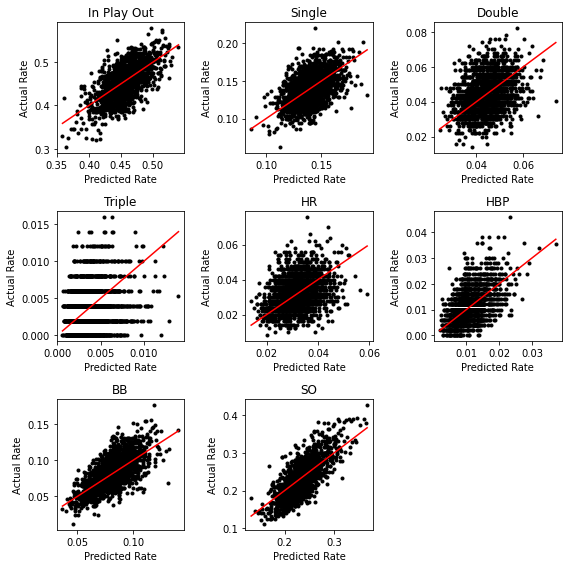

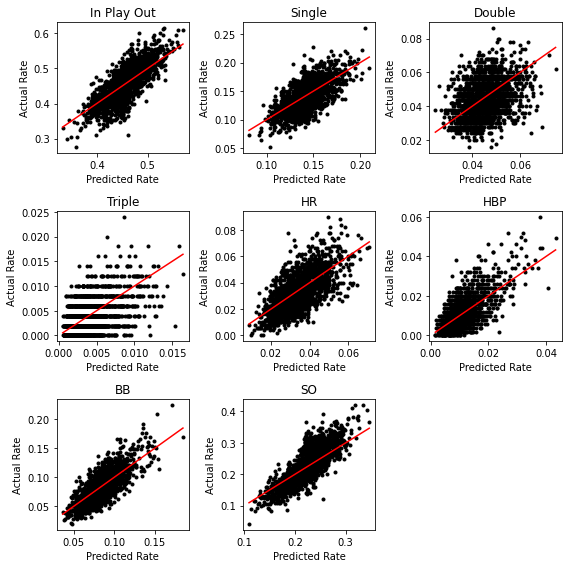

In [10]:
#sanity check
calibration2(plays[['pit_exp_outs', 'pit_exp_singles', 'pit_exp_doubles', 'pit_exp_triples', 'pit_exp_hr', 'pit_exp_hbp', 'pit_exp_walks', 'pit_exp_so']].values, plays.outcome.values)
plt.show()

calibration2(plays[['bat_exp_outs', 'bat_exp_singles', 'bat_exp_doubles', 'bat_exp_triples', 'bat_exp_hr', 'bat_exp_hbp', 'bat_exp_walks', 'bat_exp_so']].values, plays.outcome.values)
plt.show()

In [11]:
#train on plays from 2019 to 2022 and test on 2023
features = ['bat_log_outs', 'bat_log_singles', 'bat_log_doubles', 'bat_log_triples', 'bat_log_hr', 
            'bat_log_hbp', 'bat_log_walks', 'bat_log_so', 'pit_log_outs', 'pit_log_singles', 
            'pit_log_doubles', 'pit_log_triples', 'pit_log_hr', 'pit_log_hbp', 'pit_log_walks', 'pit_log_so']

train = plays.loc[(plays.year >= 2019) & (plays.year < 2023)]
test = plays.loc[plays.year == 2023]

try:
    model = LogisticRegression(penalty = 'none', fit_intercept = False, multi_class = 'multinomial', solver = 'sag').fit(train[features].values, train.outcome.values)
except:
    model = LogisticRegression(penalty = None, fit_intercept = False, multi_class = 'multinomial', solver = 'sag').fit(train[features].values, train.outcome.values)

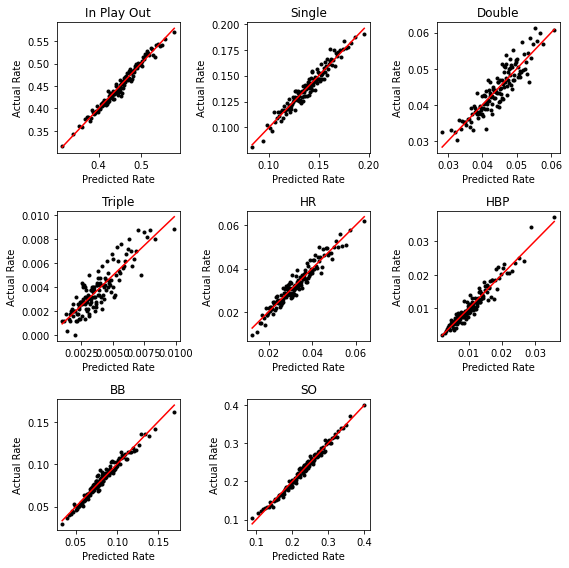

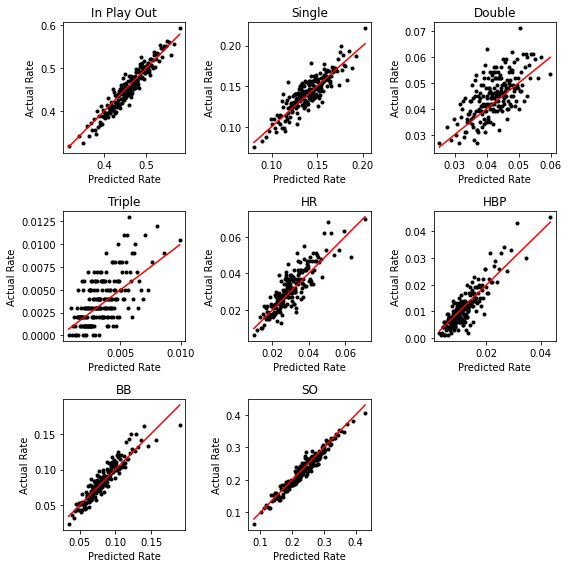

In [12]:
calibration2(model.predict_proba(train[features].values), train.outcome.values, 5000)
calibration2(model.predict_proba(test[features].values), test.outcome.values, 1000)

That looks really good!

### Matchup Dictionary

In [17]:
#for each PA outcome: bip out, single, double, triple, HR, HBP, walk, strikeout, we need a transition matrix from start 
#to end state. Some outcomes are deterministic, like walks and hbps, but some have uncertainty.
bo_states = ['___-0', '__3-0', '_2_-0', '_23-0', '1__-0', '1_3-0', '12_-0',
       '123-0', '___-1', '__3-1', '_2_-1', '_23-1', '1__-1', '1_3-1',
       '12_-1', '123-1', '___-2', '__3-2', '_2_-2', '_23-2', '1__-2',
       '1_3-2', '12_-2', '123-2']

outcome_matrices = dict()

#walks and HBP have the same transitions
m = np.zeros((25,24))
m[4,0] = 1 
m[5,1] = 1
m[6,2] = 1
m[7,3] = 1
m[6,4] = 1
m[7,5] = 1
m[7,6] = 1
m[7,7] = 1

m[12,8] = 1 
m[13,9] = 1
m[14,10] = 1
m[15,11] = 1
m[14,12] = 1
m[15,13] = 1
m[15,14] = 1
m[15,15] = 1

m[20,16] = 1 
m[21,17] = 1
m[22,18] = 1
m[23,19] = 1
m[22,20] = 1
m[23,21] = 1
m[23,22] = 1
m[23,23] = 1
outcome_matrices.update({'walk': m.copy(), 'hbp': m.copy()})

#hr's always clear the bases without increasing outs 
m = np.zeros((25,24))
m[0,0] = 1 
m[0,1] = 1 
m[0,2] = 1
m[0,3] = 1
m[0,4] = 1
m[0,5] = 1
m[0,6] = 1
m[0,7] = 1

m[8,8] = 1 
m[8,9] = 1 
m[8,10] = 1
m[8,11] = 1
m[8,12] = 1
m[8,13] = 1
m[8,14] = 1
m[8,15] = 1

m[16,16] = 1 
m[16,17] = 1 
m[16,18] = 1
m[16,19] = 1
m[16,20] = 1
m[16,21] = 1
m[16,22] = 1
m[16,23] = 1
outcome_matrices.update({'HR': m.copy()})

#triples, assuming no outs on the bases, always clear the bases and leave a runner on third with no increase in outs 
m = np.zeros((25,24))
m[1,0] = 1 
m[1,1] = 1 
m[1,2] = 1
m[1,3] = 1
m[1,4] = 1
m[1,5] = 1
m[1,6] = 1
m[1,7] = 1

m[9,8] = 1 
m[9,9] = 1 
m[9,10] = 1
m[9,11] = 1
m[9,12] = 1
m[9,13] = 1
m[9,14] = 1
m[9,15] = 1

m[17,16] = 1 
m[17,17] = 1 
m[17,18] = 1
m[17,19] = 1
m[17,20] = 1
m[17,21] = 1
m[17,22] = 1
m[17,23] = 1
outcome_matrices.update({'3b': m.copy()})

#strikeouts just increase outs by 1 
m = np.zeros((25,24))
m[8,0] = 1 
m[9,1] = 1 
m[10,2] = 1
m[11,3] = 1
m[12,4] = 1
m[13,5] = 1
m[14,6] = 1
m[15,7] = 1

m[16,8] = 1 
m[17,9] = 1 
m[18,10] = 1
m[19,11] = 1
m[20,12] = 1
m[21,13] = 1
m[22,14] = 1
m[23,15] = 1

m[24,16] = 1 
m[24,17] = 1 
m[24,18] = 1
m[24,19] = 1
m[24,20] = 1
m[24,21] = 1
m[24,22] = 1
m[24,23] = 1
outcome_matrices.update({'SO': m.copy()})

#the other three outcomes: bip outs, single, and double have some uncertainty about where the baserunners will 
#end up, so we estimate these empirically with the play by play data.
pbp = pd.read_csv('../data/retro_pbp.csv')
#remove impossible state transitions
pbp['num_brunners'] = [i.count('1') for i in pbp.bases.values.astype(str)]
pbp['new_num_brunners'] = [i.count('1') for i in pbp.new_bases.values.astype(str)]
pbp['correct_new_num_brunners'] = 1 + pbp.num_brunners.values - (pbp.new_outs.values - pbp.outs_ct.values) - pbp.runs_scored.values
pbp = pbp.loc[pbp.new_num_brunners == pbp.correct_new_num_brunners]

#I count generic outs, errors, and fielders choices as bip outs. Those are event codes 2, 18, and 19 respectively
data = pbp.loc[pbp.event_cd.isin([2,18,19])]

m = np.zeros((25,24))
for i in range(24):
    s1 = bo_states[i]
    for j in range(25):
        if j == 24:
            s2 = '3'
        else:
            s2 = bo_states[j]
        count = data.loc[(data.state == s1) & (data.new_state == s2)].shape[0]
        m[j,i] = count
#normalize columns so they sum to 1 
m = m / m.sum(axis = 0)
outcome_matrices.update({'bip_out': m.copy()})

#singles have event code 20
data = pbp.loc[pbp.event_cd == 20]
m = np.zeros((25,24))
for i in range(24):
    s1 = bo_states[i]
    for j in range(25):
        if j == 24:
            s2 = '3'
        else:
            s2 = bo_states[j]
        count = data.loc[(data.state == s1) & (data.new_state == s2)].shape[0]
        m[j,i] = count
#normalize columns so they sum to 1 
m = m / m.sum(axis = 0)
outcome_matrices.update({'1b': m.copy()})

#doubles have event code 21
data = pbp.loc[pbp.event_cd == 21]
m = np.zeros((25,24))
for i in range(24):
    s1 = bo_states[i]
    for j in range(25):
        if j == 24:
            s2 = '3'
        else:
            s2 = bo_states[j]
        count = data.loc[(data.state == s1) & (data.new_state == s2)].shape[0]
        m[j,i] = count
#normalize columns so they sum to 1 
m = m / m.sum(axis = 0)
outcome_matrices.update({'2b': m.copy()})

In [24]:
#predict the matchup outcome distribution for every batter versus every pitcher in 2023
bd23 = batter_data.loc[batter_data.year == 2023]
pd23 = pitcher_data.loc[pitcher_data.year == 2023]

matchup_pred_df = bd23.merge(pd23, on = ['stand', 'p_throws'])
matchup_pred_df[['p0','p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7']] = model.predict_proba(matchup_pred_df[features].values)

In [25]:
all_pitchers = set(matchup_pred_df.pitcher.astype(int).unique())
all_batters = set(matchup_pred_df.batter.astype(int).unique())

In [26]:
#predict a matchup outcome distribution between every batter and pitcher in our nodes
nodes = pd.read_csv('../defining_nodes/start_nodes.csv')
nodes = nodes.loc[np.isnan(nodes.home_pitcher) == False]

batters = set(nodes[['home_batting_order_' + str(i) for i in range(9)] + ['away_batting_order_' + str(i) for i in range(9)] + 
                ['home_bench_' + str(i) for i in range(6)] + ['away_bench_' + str(i) for i in range(6)]].values.astype(int).flatten())

pitchers = set(nodes[['home_pitcher', 'away_pitcher'] + ['home_bullpen_' + str(i) for i in range(15)] + 
                     ['away_bullpen_' + str(i) for i in range(15)]].values.astype(int).flatten())

outcomes = ['bip_out', '1b', '2b', '3b', 'HR', 'hbp', 'walk', 'SO']
#if a pitcher ends up batting, we use these pitcher probs
pitcher_probs = np.array([0.42, 0.093, 0.015, 0.0008, 0.005, 0.002, 0.031, 0.435]) / np.array([0.42, 0.093, 0.015, 0.0008, 0.005, 0.002, 0.031, 0.435]).sum()

In [31]:
batter_hands = dict()
matchup_dict = dict()
for pitcher in tqdm.tqdm(pitchers):
    if pitcher == -1:
        continue
        
    pitcher_dict = dict()

    #get the pitcher handedness 
    pithand = statsapi.get('people', {'personIds': pitcher})['people'][0]['pitchHand']['code']

    #check if the pitcher is in matchup df 
    if pitcher not in all_pitchers:
        #change the pitcher id 
        pitcher_matchups = matchup_pred_df.loc[(matchup_pred_df.pitcher == 0) & (matchup_pred_df.p_throws == pithand)]
    else:
        pitcher_matchups = matchup_pred_df.loc[matchup_pred_df.pitcher == pitcher]

        if pitcher_matchups.stand.unique().size < 2:
            #the pitcher has never faced a batter of a certain handedness, so just treat them as generic. They clearly don't have much sample size
            pitcher_matchups = matchup_pred_df.loc[(matchup_pred_df.pitcher == 0) & (matchup_pred_df.p_throws == pithand)]

    for batter in batters:
        if batter == -1 or batter == 10:
            continue
        #get batter handedness
        if batter in batter_hands:
            bat_hand_string = batter_hands[batter]
        else:
            bat_hand_string = statsapi.get('people', {'personIds': batter})['people'][0]['batSide']['code']
            batter_hands.update({batter: bat_hand_string})
            
        if bat_hand_string == 'S':
            if pithand == 'R':
                bathand = 'L'
            else:
                bathand = 'R'
        else:
            bathand = bat_hand_string
        
        #check if the hitter is in the matchup df 
        if batter not in all_batters:
            #use the generic batter
            matchup = pitcher_matchups.loc[(pitcher_matchups.batter == 0) & (pitcher_matchups.stand == bathand)]
        else:
            matchup = pitcher_matchups.loc[(pitcher_matchups.batter == batter) & (pitcher_matchups.stand == bathand)]

            if matchup.shape[0] == 0:
                #the batter must not have faced a pitcher of the current pitcher's handedness, so set them to genric
                matchup = pitcher_matchups.loc[(pitcher_matchups.batter == 0) & (pitcher_matchups.stand == bathand)]

        #get the preds from matchup_df. 
        preds = matchup[['p0','p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7']].values

        #the values in preds are bip out, single, double, triple, hr, hbp, walk, so
        tmatrix = np.zeros((25,24))
        for i in range(len(outcomes)):
            tmatrix += outcome_matrices[outcomes[i]] * preds[0,i]
        pitcher_dict.update({batter:tmatrix})

    #each pitcher also needs a matchup with a pitcher batter. I give the pitcher key 0 so that spark can infer the dict
    tmatrix = np.zeros((25,24))
    for i in range(len(outcomes)):
        tmatrix += outcome_matrices[outcomes[i]] * pitcher_probs[i]
    pitcher_dict.update({'pitcher': tmatrix})
    if pitcher in matchup_dict:
        matchup_dict[pitcher].update(pitcher_dict)
    else:
        matchup_dict.update({pitcher: pitcher_dict})

100%|████████████████████████████████████████████████████████████████████████████████| 813/813 [15:21<00:00,  1.13s/it]


In [32]:
np.save('matchup_dict.npy', matchup_dict)